# Arcana Soundtrack Lyrics Act Prediction

In [1]:
#import library
import numpy as np
import pandas as pd
import seaborn as sns
import nltk
import math
nltk.download('wordnet')
from textblob import TextBlob
from wordcloud import WordCloud
import re
import string
string.punctuation
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import metrics

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Data Extraction

In [2]:
df = pd.read_csv('../input/arcane-soundtrack-lyrics/Arcane/arcane_soundtrack.csv')

In [3]:
df.shape

(560, 7)

In [4]:
df.head()

track_number track_title     artists  instrumental  \
0             1  Playground  Bea Miller         False   
1             1  Playground  Bea Miller         False   
2             1  Playground  Bea Miller         False   
3             1  Playground  Bea Miller         False   
4             1  Playground  Bea Miller         False   

                                lyrics  hotness  Act  
0     Who told you what was down here?    False    1  
1      Come along if you wanted a peek    False    1  
2      I've seen your face around here    False    1  
3  Come alone, tell me under the table    False    1  
4                    What do you seek?    False    1

In [5]:
df.describe()

track_number         Act
count    560.000000  560.000000
mean       6.048214    2.408929
std        2.807382    0.810657
min        1.000000    1.000000
25%        4.000000    2.000000
50%        6.000000    3.000000
75%        8.000000    3.000000
max       11.000000    3.000000

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 560 entries, 0 to 559
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   track_number  560 non-null    int64 
 1   track_title   560 non-null    object
 2   artists       560 non-null    object
 3   instrumental  560 non-null    bool  
 4   lyrics        503 non-null    object
 5   hotness       560 non-null    bool  
 6   Act           560 non-null    int64 
dtypes: bool(2), int64(2), object(3)
memory usage: 23.1+ KB


In [7]:
#handling missing value
df.dropna(inplace = True)

# Natural Language Processing

In [8]:
#selection data
text = df[['lyrics']]
text.head()

lyrics
0     Who told you what was down here?
1      Come along if you wanted a peek
2      I've seen your face around here
3  Come alone, tell me under the table
4                    What do you seek?

## Removal Punctuation

In [9]:
#defining to remove punctuation
def remove_punctuation(text):
    punctuationfree = "".join([i for i in text if i not in string.punctuation])
    return punctuationfree

text['lyrics_punctuation'] = text['lyrics'].apply(lambda text: remove_punctuation(text))
text.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


lyrics                  lyrics_punctuation
0     Who told you what was down here?     Who told you what was down here
1      Come along if you wanted a peek     Come along if you wanted a peek
2      I've seen your face around here      Ive seen your face around here
3  Come alone, tell me under the table  Come alone tell me under the table
4                    What do you seek?                    What do you seek

## Lower Casing

In [10]:
#setting lower case
text['lyrics_lower'] = text['lyrics_punctuation'].str.lower()
text.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


lyrics                  lyrics_punctuation  \
0     Who told you what was down here?     Who told you what was down here   
1      Come along if you wanted a peek     Come along if you wanted a peek   
2      I've seen your face around here      Ive seen your face around here   
3  Come alone, tell me under the table  Come alone tell me under the table   
4                    What do you seek?                    What do you seek   

                         lyrics_lower  
0     who told you what was down here  
1     come along if you wanted a peek  
2      ive seen your face around here  
3  come alone tell me under the table  
4                    what do you seek

## Tokenization

In [11]:
#defining function for tokenization
def tokenization(text):
    tokens = re.split('W+', text)
    return tokens

#applying function to the column
text['lyrics_tokenied'] = text['lyrics_lower'].apply(lambda x: tokenization(x))
text.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


lyrics                  lyrics_punctuation  \
0     Who told you what was down here?     Who told you what was down here   
1      Come along if you wanted a peek     Come along if you wanted a peek   
2      I've seen your face around here      Ive seen your face around here   
3  Come alone, tell me under the table  Come alone tell me under the table   
4                    What do you seek?                    What do you seek   

                         lyrics_lower                       lyrics_tokenied  
0     who told you what was down here     [who told you what was down here]  
1     come along if you wanted a peek     [come along if you wanted a peek]  
2      ive seen your face around here      [ive seen your face around here]  
3  come alone tell me under the table  [come alone tell me under the table]  
4                    what do you seek                    [what do you seek]

## Removal Stopwords

In [12]:
#stop words present in the library
stopwords = nltk.corpus.stopwords.words('english')

#defining the function to remove stopwords from tokenized text
def remove_stopwords(text):
    output= [i for i in text if i not in stopwords]
    return output

#applying the function
text['no_stopword'] = text['lyrics_tokenied'].apply(lambda x:remove_stopwords(x))
text.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


lyrics                  lyrics_punctuation  \
0     Who told you what was down here?     Who told you what was down here   
1      Come along if you wanted a peek     Come along if you wanted a peek   
2      I've seen your face around here      Ive seen your face around here   
3  Come alone, tell me under the table  Come alone tell me under the table   
4                    What do you seek?                    What do you seek   

                         lyrics_lower                       lyrics_tokenied  \
0     who told you what was down here     [who told you what was down here]   
1     come along if you wanted a peek     [come along if you wanted a peek]   
2      ive seen your face around here      [ive seen your face around here]   
3  come alone tell me under the table  [come alone tell me under the table]   
4                    what do you seek                    [what do you seek]   

                            no_stopword  
0     [who told you what was down here]  
1     [come along if you wanted a peek]  
2      [ive seen your face around here]  
3  [come alone tell me under the table]  
4                    [what do you seek]

## Stemming

In [13]:
#defining the object for stemming
porter_stemmer = PorterStemmer()

#defining a function for stemming
def stemming(text):
    stem_text = [porter_stemmer.stem(word) for word in text]
    return stem_text

#applying the function
text['lyrics_stemmend'] = text['no_stopword'].apply(lambda x: stemming(x))
text.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


lyrics                  lyrics_punctuation  \
0     Who told you what was down here?     Who told you what was down here   
1      Come along if you wanted a peek     Come along if you wanted a peek   
2      I've seen your face around here      Ive seen your face around here   
3  Come alone, tell me under the table  Come alone tell me under the table   
4                    What do you seek?                    What do you seek   

                         lyrics_lower                       lyrics_tokenied  \
0     who told you what was down here     [who told you what was down here]   
1     come along if you wanted a peek     [come along if you wanted a peek]   
2      ive seen your face around here      [ive seen your face around here]   
3  come alone tell me under the table  [come alone tell me under the table]   
4                    what do you seek                    [what do you seek]   

                            no_stopword                    lyrics_stemmend  
0     [who told you what was down here]   [who told you what was down her]  
1     [come along if you wanted a peek]  [come along if you wanted a peek]  
2      [ive seen your face around here]    [ive seen your face around her]  
3  [come alone tell me under the table]   [come alone tell me under the t]  
4                    [what do you seek]                 [what do you seek]

## Lemmatization

In [14]:
#defining the object for lemmatizing
lemmatizer = WordNetLemmatizer()

#defining a function for lemmatizing
def lemmatize_words(text):
    lemma_text = [lemmatizer.lemmatize(word) for word in text]
    return lemma_text
                
#applying the function
text['lyrics_lemmatized'] = text['lyrics_stemmend'].apply(lambda text: lemmatize_words(text))
text.head()

lyrics                  lyrics_punctuation  \
0     Who told you what was down here?     Who told you what was down here   
1      Come along if you wanted a peek     Come along if you wanted a peek   
2      I've seen your face around here      Ive seen your face around here   
3  Come alone, tell me under the table  Come alone tell me under the table   
4                    What do you seek?                    What do you seek   

                         lyrics_lower                       lyrics_tokenied  \
0     who told you what was down here     [who told you what was down here]   
1     come along if you wanted a peek     [come along if you wanted a peek]   
2      ive seen your face around here      [ive seen your face around here]   
3  come alone tell me under the table  [come alone tell me under the table]   
4                    what do you seek                    [what do you seek]   

                            no_stopword                    lyrics_stemmend  \
0     [who told you what was down here]   [who told you what was down her]   
1     [come along if you wanted a peek]  [come along if you wanted a peek]   
2      [ive seen your face around here]    [ive seen your face around her]   
3  [come alone tell me under the table]   [come alone tell me under the t]   
4                    [what do you seek]                 [what do you seek]   

                   lyrics_lemmatized  
0   [who told you what was down her]  
1  [come along if you wanted a peek]  
2    [ive seen your face around her]  
3   [come alone tell me under the t]  
4                 [what do you seek]

In [15]:
#selection data
sentiment = text[['lyrics_punctuation']]
sentiment.head()

lyrics_punctuation
0     Who told you what was down here
1     Come along if you wanted a peek
2      Ive seen your face around here
3  Come alone tell me under the table
4                    What do you seek

In [16]:
#create function to get subjectivity
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

#create function to get polarity
def getPolarity(text):
    return TextBlob(text).sentiment.polarity

#apply function to data 
sentiment['subjectivity'] = sentiment['lyrics_punctuation'].apply(getSubjectivity)
sentiment['polarity'] = sentiment['lyrics_punctuation'].apply(getPolarity)
sentiment.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


lyrics_punctuation  subjectivity  polarity
0     Who told you what was down here      0.288889 -0.155556
1     Come along if you wanted a peek      0.000000  0.000000
2      Ive seen your face around here      0.000000  0.000000
3  Come alone tell me under the table      0.000000  0.000000
4                    What do you seek      0.000000  0.000000

In [17]:
#create function to get sentiment data
def getSentiment(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'

#apply function to data
sentiment['sentiment'] = sentiment['polarity'].apply(getSentiment)
sentiment.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


lyrics_punctuation  subjectivity  polarity sentiment
0     Who told you what was down here      0.288889 -0.155556  Negative
1     Come along if you wanted a peek      0.000000  0.000000   Neutral
2      Ive seen your face around here      0.000000  0.000000   Neutral
3  Come alone tell me under the table      0.000000  0.000000   Neutral
4                    What do you seek      0.000000  0.000000   Neutral

# Visualization

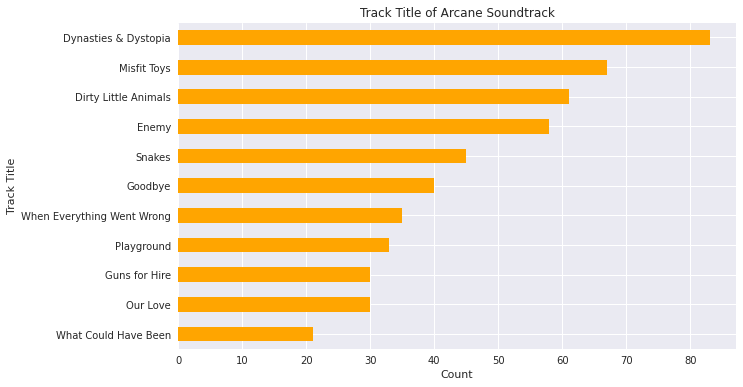

In [18]:
#visualize track title
plt.figure(figsize = (10,6))
df['track_title'].value_counts().sort_values().plot(kind = 'barh', color = 'orange')
plt.title("Track Title of Arcane Soundtrack")
plt.xlabel("Count")
plt.ylabel("Track Title")
plt.show()

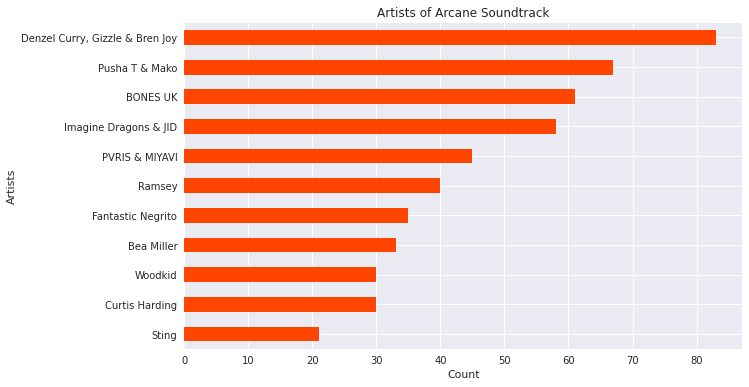

In [19]:
#visualize artists
plt.figure(figsize = (10,6))
df['artists'].value_counts().sort_values().plot(kind = 'barh', color = 'orangered')
plt.title("Artists of Arcane Soundtrack")
plt.xlabel("Count")
plt.ylabel("Artists")
plt.show()

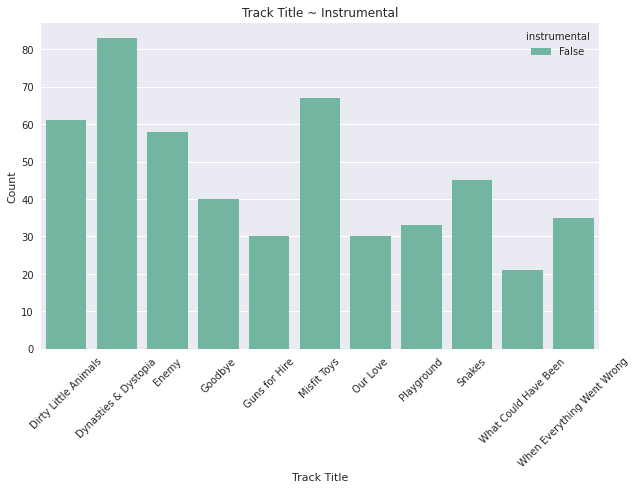

In [20]:
#group track title & instrumental
track_instrumental = df.groupby(['track_title', 'instrumental']).size().reset_index(name = 'Count')

#visualize track title ~ instrumental
plt.figure(figsize = (10,6))
chart = sns.barplot(data = track_instrumental, x = 'track_title', y = 'Count', hue = 'instrumental', palette  = 'Set2')
chart.set_xticklabels(chart.get_xticklabels(), rotation = 45)
plt.title("Track Title ~ Instrumental")
plt.xlabel("Track Title")
plt.ylabel("Count")
plt.show()

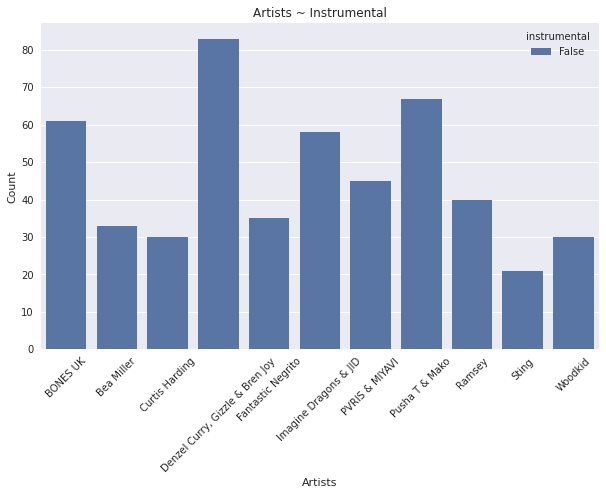

In [21]:
#group artists & instrumental
artist_instrumental = df.groupby(['artists', 'instrumental']).size().reset_index(name = 'Count')

#visualize artists ~ instrumental
plt.figure(figsize = (10,6))
chart = sns.barplot(data = artist_instrumental, x = 'artists', y = 'Count', hue = 'instrumental')
chart.set_xticklabels(chart.get_xticklabels(), rotation = 45)
plt.title("Artists ~ Instrumental")
plt.xlabel("Artists")
plt.ylabel("Count")
plt.show()

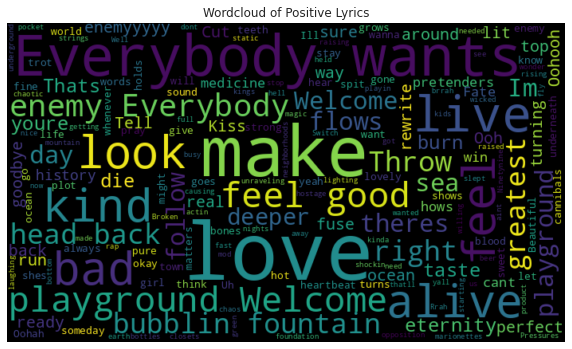

In [22]:
#visualize positive sentiment of lyrics
positive = " ".join(sentiment[sentiment.sentiment == 'Positive']['lyrics_punctuation'].values)
w = WordCloud(width = 700, height = 400, random_state = 10, max_font_size = 100).generate(positive)

plt.figure(figsize = (10,6))
plt.imshow(w, interpolation = "bilinear")
plt.title("Wordcloud of Positive Lyrics")
plt.axis('off')
plt.show()

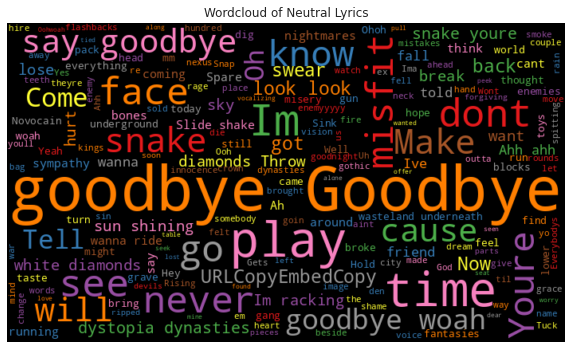

In [23]:
#visualize neutral sentiment of lyrics
neutral = " ".join(sentiment[sentiment.sentiment == 'Neutral']['lyrics_punctuation'].values)
w = WordCloud(width = 700, height = 400, random_state = 10, max_font_size = 100, colormap = 'Set1').generate(neutral)

plt.figure(figsize = (10,6))
plt.imshow(w, interpolation = "bilinear")
plt.title("Wordcloud of Neutral Lyrics")
plt.axis('off')
plt.show()

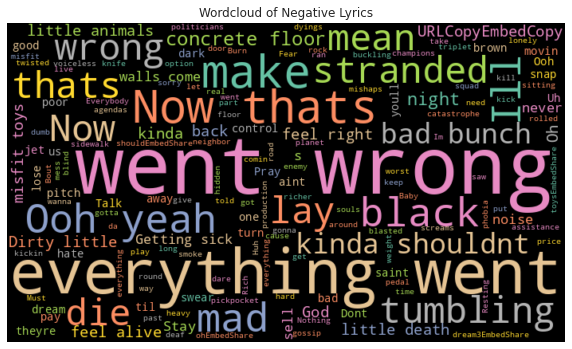

In [24]:
#visualize negative sentiment of lyrics
negative = " ".join(sentiment[sentiment.sentiment == 'Negative']['lyrics_punctuation'].values)
w = WordCloud(width = 700, height = 400, random_state = 10, max_font_size = 100, colormap = 'Set2').generate(negative)

plt.figure(figsize = (10,6))
plt.imshow(w, interpolation = "bilinear")
plt.title("Wordcloud of Negative Lyrics")
plt.axis('off')
plt.show()

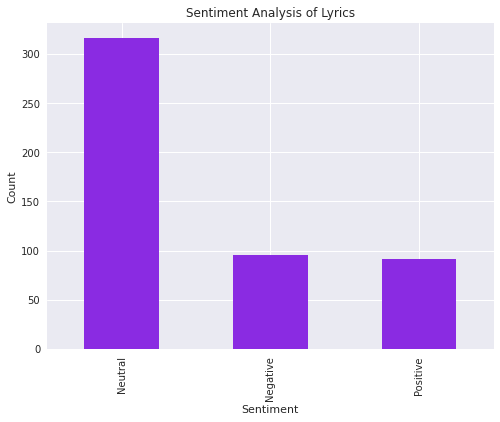

In [25]:
#visualize sentiment
plt.figure(figsize = (8,6))
plt.xlabel('Sentiment')
plt.ylabel('Count')
sentiment['sentiment'].value_counts().plot(kind = 'bar', color = 'blueviolet')
plt.title("Sentiment Analysis of Lyrics")
plt.show()

# K-Nearest Neighbors Model

In [26]:
#handling categorical data
for i in df.columns.tolist():
    df[i] = df[i].astype('category').cat.codes

df.head()

track_number  track_title  artists  instrumental  lyrics  hotness  Act
0             0            7        1             0     328        0    0
1             0            7        1             0      48        0    0
2             0            7        1             0     144        0    0
3             0            7        1             0      47        0    0
4             0            7        1             0     316        0    0

In [27]:
#split data
X = df.drop('Act', axis = 1)
y = df['Act']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(352, 6)
(352,)
(151, 6)
(151,)


In [28]:
#setup arrays to store training and test accuracy
neighbors = np.arange(1,9)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

for i,k in enumerate(neighbors):
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    train_accuracy[i] = knn.score(X_train, y_train)
    test_accuracy[i] = knn.score(X_test, y_test) 

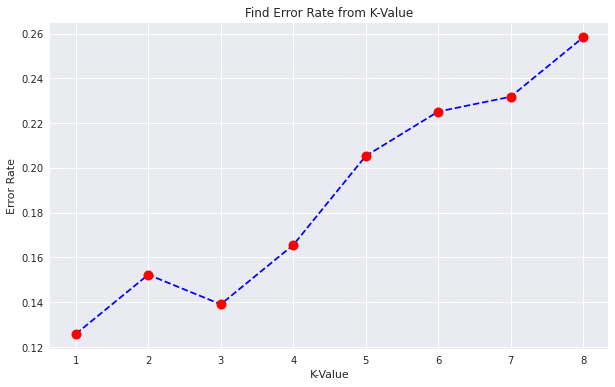

In [29]:
#find good K-value from error rate
error_rate = []

for i in range(1,9):
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))
    
plt.figure(figsize = (10, 6))
plt.plot(range(1,9), error_rate, color ='blue',
                linestyle ='dashed', marker ='o',
                markerfacecolor ='red', markersize = 10)

plt.title('Find Error Rate from K-Value')
plt.xlabel('K-Value')
plt.ylabel('Error Rate')
plt.show()

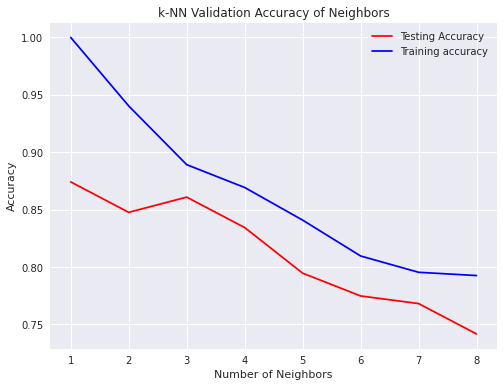

In [30]:
#visualize knn model for training and testing
plt.figure(figsize = (8,6))
plt.title('k-NN Validation Accuracy of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy', color = 'r')
plt.plot(neighbors, train_accuracy, label = 'Training accuracy', color = 'b')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

In [31]:
#build model
knn = KNeighborsClassifier(n_neighbors = 3)
%time knn.fit(X_train, y_train)
knn.score(X_test, y_test)

CPU times: user 3.31 ms, sys: 51 µs, total: 3.36 ms
Wall time: 3.1 ms


0.8609271523178808

In [32]:
#prediction
y_pred = knn.predict(X_test)
print(y_pred)

[0 0 2 2 2 0 2 2 2 2 2 1 2 1 1 2 2 1 2 0 2 2 2 2 0 2 0 2 0 2 2 2 2 2 0 1 2
 2 2 1 2 0 2 2 1 0 2 2 2 1 2 1 1 2 2 0 2 1 2 2 1 2 2 2 2 1 0 2 2 2 2 2 2 2
 1 2 2 0 2 2 2 1 1 2 2 2 2 2 2 0 2 2 2 2 2 2 0 2 0 2 2 0 1 2 0 2 2 2 2 2 2
 0 2 0 1 2 2 2 1 1 2 0 2 1 2 2 0 2 2 2 2 2 0 0 2 2 1 2 1 2 2 0 1 0 2 0 2 2
 2 0 2]


In [33]:
#report of MSE & RMSE
mse = metrics.mean_squared_error(y_test, y_pred)
print('Mean Squared Error : '+ str(mse))
rmse = math.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error : '+ str(rmse))

Mean Squared Error : 0.2185430463576159
Root Mean Squared Error : 0.4674858782440555


[[25  5  2]
 [ 1 17  9]
 [ 2  2 88]]


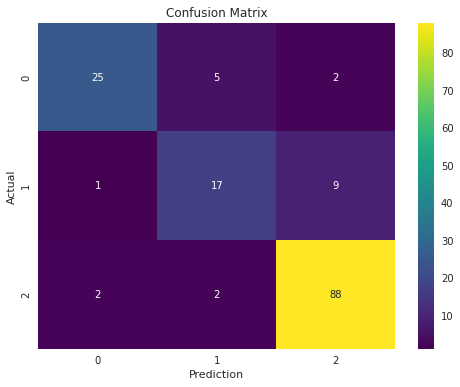

In [34]:
#confusion matrix
matrix = metrics.confusion_matrix(y_test, y_pred)
print(matrix)

#heatmap matrix
plt.figure(figsize = (8,6))
sns.heatmap(matrix, annot = True, fmt = '.0f', cmap = 'viridis')
plt.title("Confusion Matrix")
plt.xlabel("Prediction")
plt.ylabel("Actual")
plt.show()

In [35]:
#classification report
report = metrics.classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.89      0.78      0.83        32
           1       0.71      0.63      0.67        27
           2       0.89      0.96      0.92        92

    accuracy                           0.86       151
   macro avg       0.83      0.79      0.81       151
weighted avg       0.86      0.86      0.86       151

